CODE BLOCK: 1

In [1]:
!pip install torchsummary


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import model as mymodels
import utils as myutils

CODE BLOCK: 2

In [3]:
# CUDA?
# cuda = torch.cuda.is_available()
# print("CUDA Available?", cuda)
print("Apple MPS Available?", torch.backends.mps.is_available())
device = torch.device("mps:0")
torch.set_default_device(device)


Apple MPS Available? True


CODE BLOCK: 3

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [5]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [6]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs, generator=torch.Generator(device="mps:0"))
train_loader = torch.utils.data.DataLoader(train_data, **kwargs, generator=torch.Generator(device="mps:0"))

CODE BLOCK: 6

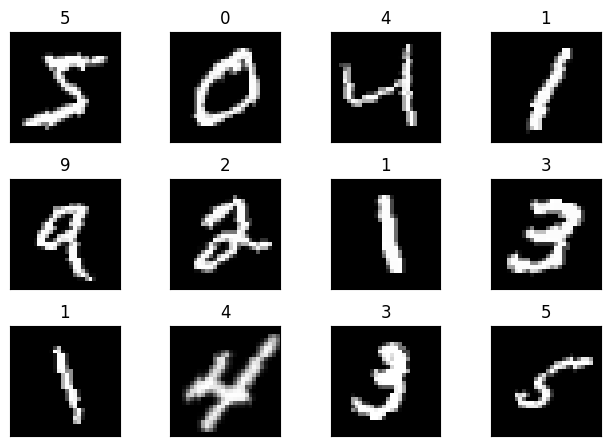

In [7]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [8]:
model = mymodels.Net().to(device)
model.summary(input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [9]:
model = mymodels.Net2().to(device)
model.summary(input_size=(1, 28, 28))


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------


CODE BLOCK: 8

In [10]:
model = mymodels.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 5

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  myutils.train(model, device, train_loader, optimizer, criterion)
  myutils.test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.5697 Batch_id=117 Accuracy=39.48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:07<00:00, 16.10it/s]


Test set: Average loss: 0.4338, Accuracy: 8568/10000 (85.68%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2883 Batch_id=117 Accuracy=91.39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.96it/s]


Test set: Average loss: 0.1009, Accuracy: 9691/10000 (96.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2835 Batch_id=117 Accuracy=95.82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.62it/s]


Test set: Average loss: 0.0679, Accuracy: 9768/10000 (97.68%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.2493 Batch_id=117 Accuracy=96.96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.43it/s]


Test set: Average loss: 0.0566, Accuracy: 9812/10000 (98.12%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1930 Batch_id=117 Accuracy=97.43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.46it/s]


Test set: Average loss: 0.0461, Accuracy: 9844/10000 (98.44%)

Adjusting learning rate of group 0 to 1.0000e-02.


CODE BLOCK: 10

Text(0.5, 1.0, 'Test Accuracy')

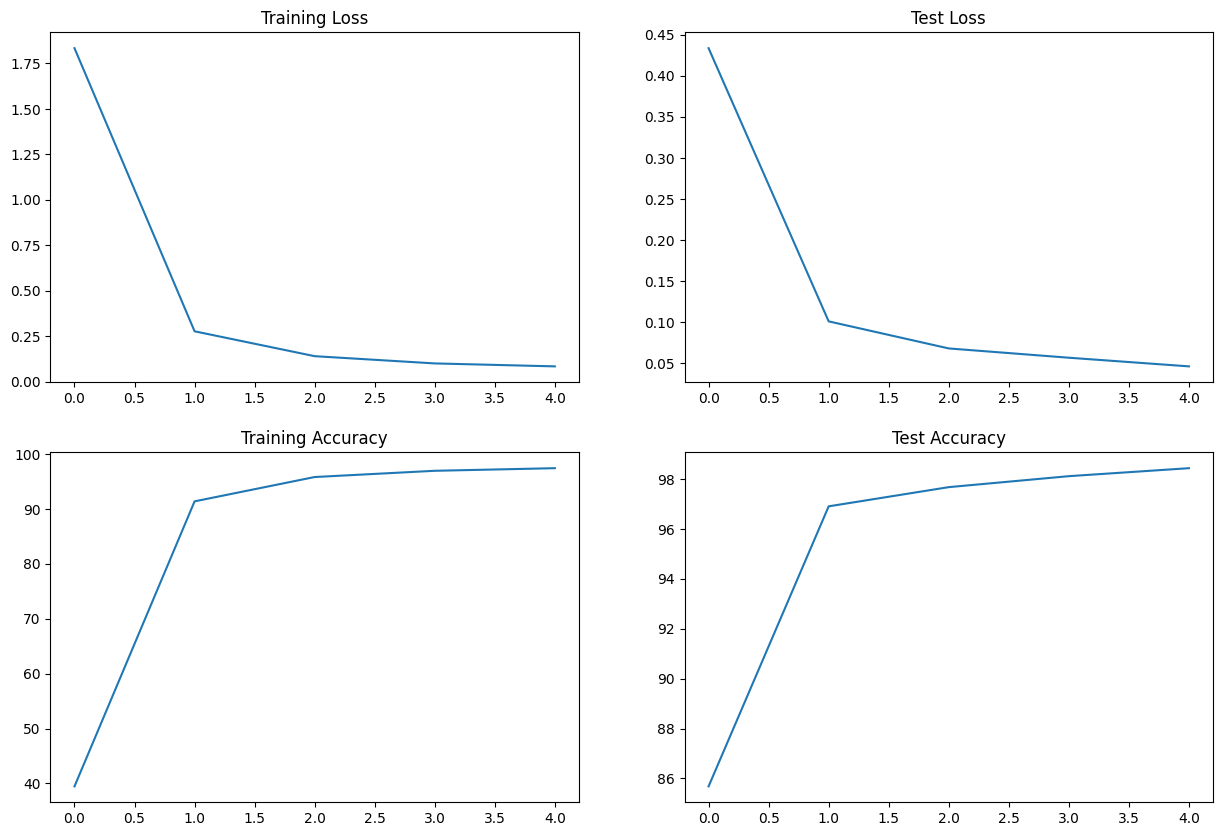

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(myutils.train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(myutils.train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(myutils.test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(myutils.test_acc)
axs[1, 1].set_title("Test Accuracy")